In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge customer data with their corresponding transaction details
merged_data = pd.merge(transactions, customers, on='CustomerID')

# Feature engineering - aggregating transaction data per customer
customer_data = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    transaction_count=('TransactionID', 'count'),
    average_spend=('TotalValue', 'mean'),
    average_quantity=('Quantity', 'mean')
).reset_index()

# Encode categorical variables
customer_data = customer_data.merge(customers[['CustomerID', 'Region']], on='CustomerID')
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.iloc[:, 1:])


In [51]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)  # Use 3 components for better representation
pca_data = pca.fit_transform(scaled_data)

In [52]:
# Test different k values (2 to 10 clusters) for KMeans and GMM
db_scores_kmeans = []
db_scores_gmm = []
silhouette_scores_kmeans = []
silhouette_scores_gmm = []
ch_scores_kmeans = []
ch_scores_gmm = []

for k in range(2, 11):
    # KMeans
    kmeans = KMeans(n_clusters=k, n_init=20, init='k-means++', random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    
    # GMM
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(pca_data)
    
    # Compute DB Index for KMeans and GMM
    db_scores_kmeans.append(davies_bouldin_score(pca_data, kmeans_labels))
    db_scores_gmm.append(davies_bouldin_score(pca_data, gmm_labels))
    
    # Compute Silhouette Scores
    silhouette_scores_kmeans.append(silhouette_score(pca_data, kmeans_labels))
    silhouette_scores_gmm.append(silhouette_score(pca_data, gmm_labels))
    
    # Compute Calinski-Harabasz Scores
    ch_scores_kmeans.append(calinski_harabasz_score(pca_data, kmeans_labels))
    ch_scores_gmm.append(calinski_harabasz_score(pca_data, gmm_labels))


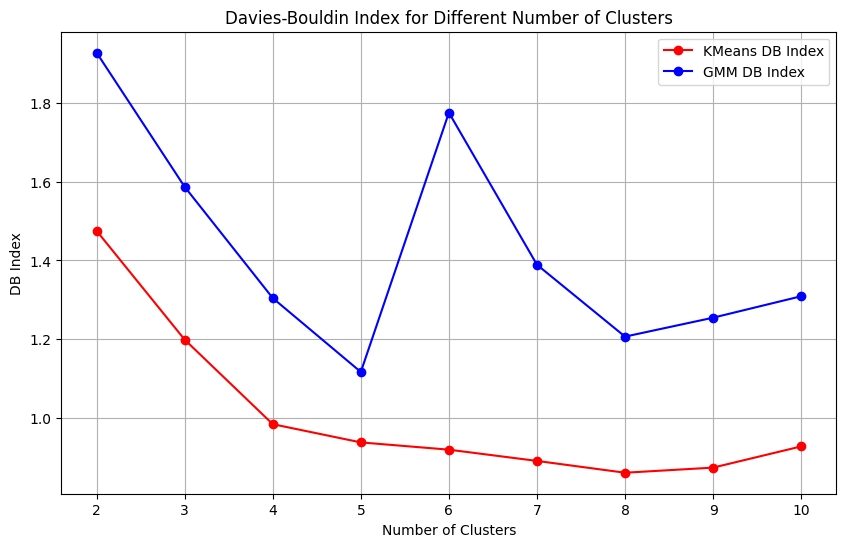

In [53]:
# Plot the DB Index for KMeans and GMM
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), db_scores_kmeans, marker='o', color='r', label='KMeans DB Index')
plt.plot(range(2, 11), db_scores_gmm, marker='o', color='b', label='GMM DB Index')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.grid(True)
plt.xticks(range(2, 11))
plt.legend()
plt.show()

In [54]:
# DBSCAN: Run DBSCAN with various eps values
db_scores_dbscan = []
silhouette_scores_dbscan = []
ch_scores_dbscan = []

for eps in [0.3, 0.4, 0.5, 0.6, 0.7]:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(pca_data)
    
    # Compute DB Index for DBSCAN (excluding noise points labeled as -1)
    if len(set(dbscan_labels)) > 1:  # Exclude noise
        db_scores_dbscan.append(davies_bouldin_score(pca_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]))
        silhouette_scores_dbscan.append(silhouette_score(pca_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]))
        ch_scores_dbscan.append(calinski_harabasz_score(pca_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1]))
    else:
        db_scores_dbscan.append(float('nan'))
        silhouette_scores_dbscan.append(float('nan'))
        ch_scores_dbscan.append(float('nan'))


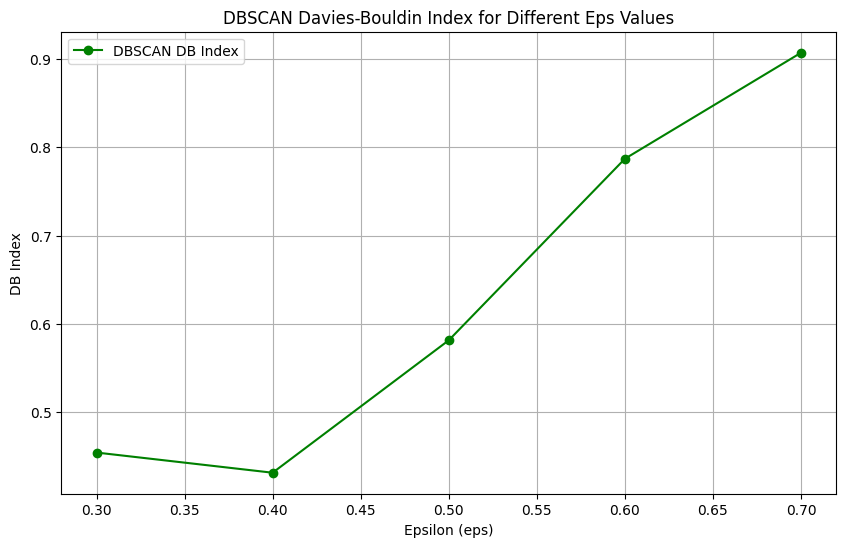

In [37]:
# Plot DBSCAN Metrics
plt.figure(figsize=(10, 6))
plt.plot([0.3, 0.4, 0.5, 0.6, 0.7], db_scores_dbscan, marker='o', color='g', label='DBSCAN DB Index')
plt.title('DBSCAN Davies-Bouldin Index for Different Eps Values')
plt.xlabel('Epsilon (eps)')
plt.ylabel('DB Index')
plt.grid(True)
plt.legend()
plt.show()

In [55]:
# Print results for KMeans, GMM, and DBSCAN
optimal_k_kmeans = range(2, 11)[db_scores_kmeans.index(min(db_scores_kmeans))]
optimal_k_gmm = range(2, 11)[db_scores_gmm.index(min(db_scores_gmm))]
optimal_eps_dbscan = [0.3, 0.4, 0.5, 0.6, 0.7][db_scores_dbscan.index(min(db_scores_dbscan))]

print(f"Optimal Number of Clusters (KMeans): {optimal_k_kmeans}")
print(f"Optimal Number of Clusters (GMM): {optimal_k_gmm}")
print(f"Optimal Epsilon for DBSCAN: {optimal_eps_dbscan}")


Optimal Number of Clusters (KMeans): 8
Optimal Number of Clusters (GMM): 5
Optimal Epsilon for DBSCAN: 0.4


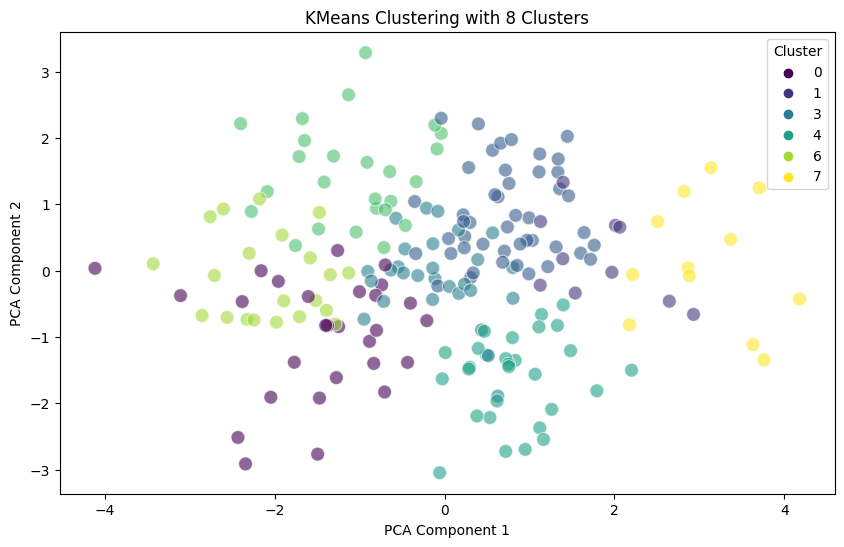

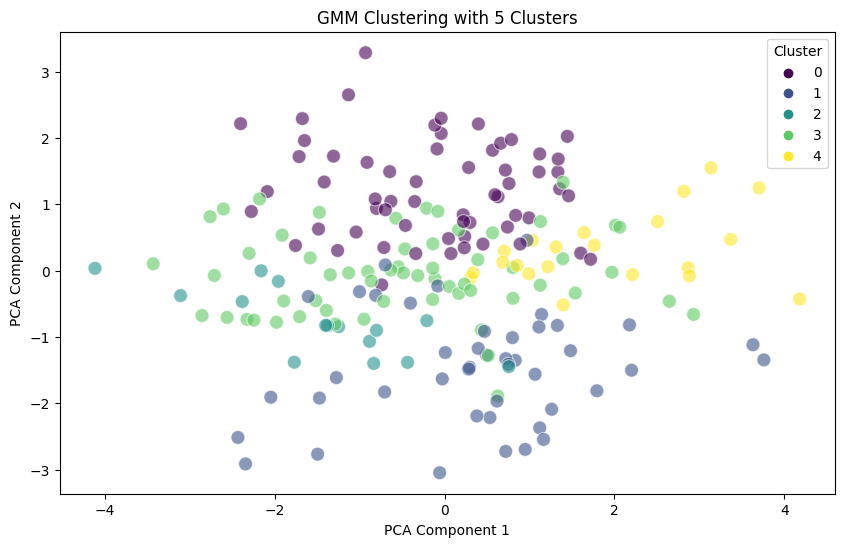

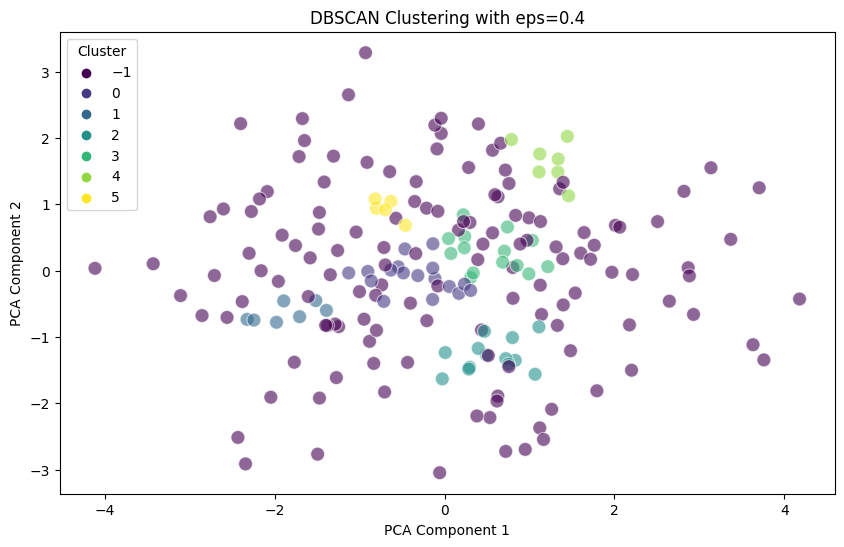

In [56]:
# Final clustering and visualization for KMeans, GMM, and DBSCAN (using optimal k/eps)
# KMeans
kmeans = KMeans(n_clusters=optimal_k_kmeans, n_init=50, init='k-means++', random_state=42)
kmeans_labels = kmeans.fit_predict(pca_data)

# GMM
gmm = GaussianMixture(n_components=optimal_k_gmm, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(pca_data)

# DBSCAN
dbscan = DBSCAN(eps=optimal_eps_dbscan, min_samples=5)
dbscan_labels = dbscan.fit_predict(pca_data)

# Plot KMeans, GMM, and DBSCAN clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=kmeans_labels, palette='viridis', s=100, alpha=0.6)
plt.title(f'KMeans Clustering with {optimal_k_kmeans} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=gmm_labels, palette='viridis', s=100, alpha=0.6)
plt.title(f'GMM Clustering with {optimal_k_gmm} Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=dbscan_labels, palette='viridis', s=100, alpha=0.6)
plt.title(f'DBSCAN Clustering with eps={optimal_eps_dbscan}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [57]:
# Print final clustering metrics
print(f"K-Means DB Index: {davies_bouldin_score(pca_data, kmeans_labels)}")
print(f"GMM DB Index: {davies_bouldin_score(pca_data, gmm_labels)}")
print(f"DBSCAN DB Index: {davies_bouldin_score(pca_data[dbscan_labels != -1], dbscan_labels[dbscan_labels != -1])}")


K-Means DB Index: 0.8522865454011668
GMM DB Index: 1.1166746847810611
DBSCAN DB Index: 0.4315528851509069
